# 08 - Billboard + Lyrics

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns

from gensim.models import Word2Vec
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from wordcloud import WordCloud

#sns.set(context='poster', style='white')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'arial'

# %config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

## Load data

In [2]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')
df.sample(3)

,artist_all,artist_base,rank,song,year,artist_featured,song_clean,artist_clean,lyrics,danceability,...,tempo,time_signature,popularity,explicit,duration_min,num_words,words_per_sec,num_uniq_words,decade,uniq_ratio
3047,mc hammer,mc hammer,47,have you seen her,1990,NaN,have you seen her,mc hammer,ah yeah im glad i put this tape in im just gon...,0.761,...,144.353,4.0,23.0,False,4.720667,482.0,1.701737,187.0,1990,0.387967
5590,sia,sia,90,chandelier,2015,NaN,chandelier,sia,party girls dont get hurt cant feel anything ...,0.399,...,117.089,5.0,81.0,False,3.602000,375.0,1.735147,90.0,2010,0.240000
5816,dua lipa,dua lipa,16,new rules,2018,NaN,new rules,dua lipa,one one one one one talkin in my sleep at nig...,0.762,...,116.078,4.0,3.0,False,3.488667,153.0,0.730938,79.0,2010,0.516340


In [3]:
df_nonnull= df[df['lyrics'].notnull()]
lyrics = df_nonnull['lyrics']
lyrics

0       theres a summer place where it may rain or sto...
1       put your sweet lips a little closer to the pho...
2        dont want your love any more dont want your k...
3       on the bank of the river stood running bear yo...
4       teen angel teen angel teen angel that fateful ...
                              ...                        
6296     its a beautiful day shes been crying all nigh...
6297     sit by myself talking to the moon teh ha pull...
6298     mummy dont know daddys getting hot at the bod...
6299     you and i had this off and on so long youve b...
6300     i swear i dont know how i trusted a montero w...
Name: lyrics, Length: 6250, dtype: object

## Most decade specific words

In [4]:
# when creating word clouds, maps word fontsize to a color
from random import Random


class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

In [5]:
audio_features = ['acousticness', 'danceability', 'duration_min', 'energy',
                  'explicit', 'instrumentalness', 'key', 'liveness', 'loudness',
                  'mode', 'popularity', 'speechiness', 'tempo',
                  'time_signature', 'valence', 'year']

# get sorted list of top artists
df_pop = df[df['popularity'].notnull()]
top_artists = df_pop.groupby('artist_clean')['song']\
                      .count()\
                      .sort_values(ascending=False)\
                      .index

# get audio features for each song and rename index
X_entity_dfs = list() # list of dataframes to be eventually be concantenated
X_songs = df_pop[audio_features].set_index(df_pop['song'])
X_songs.index = [str('song_') + val for val in X_songs.index]
X_entity_dfs.append(X_songs)

# get audio features for each artist as mean of artists' songs
# rename index and add to X_entity_dfs
X_artists = df_pop.groupby('artist_clean')[audio_features].mean()
X_artists = X_artists.reindex(top_artists).iloc[:20,:]
X_artists.index = [str('artist_') + val for val in X_artists.index]
X_entity_dfs.append(X_artists)

In [6]:
# make features and targets
X = lyrics.copy()
y = df_nonnull['decade']
X.head(), y.head()

(0    theres a summer place where it may rain or sto...
 1    put your sweet lips a little closer to the pho...
 2     dont want your love any more dont want your k...
 3    on the bank of the river stood running bear yo...
 4    teen angel teen angel teen angel that fateful ...
 Name: lyrics, dtype: object,
 0    1960
 1    1960
 2    1960
 3    1960
 4    1960
 Name: decade, dtype: int64)

In [7]:
# make and fit Naive Bayes model
stop_words = list(ENGLISH_STOP_WORDS)
stop_words.extend(['shes', 'yes', 'didnt'])
pipe = Pipeline([('count', CountVectorizer(min_df=50, binary=True,
                                ngram_range=(1,1), stop_words=stop_words)),
                    ('bnb', BernoulliNB(binarize=0))])
pipe.fit(X, y)


Pipeline(steps=[('count',
                 CountVectorizer(binary=True, min_df=50,
                                 stop_words=['next', 'etc', 'their', 'ours',
                                             'too', 'about', 'each', 'no',
                                             'seemed', 'should', 'of', 'up',
                                             'were', 'during', 'was', 'now',
                                             'thick', 'yet', 'twelve', 'mine',
                                             'thru', 'six', 'us', 'else',
                                             'therein', 'already', 'seeming',
                                             'than', 'onto', 'whom', ...])),
                ('bnb', BernoulliNB(binarize=0))])

In [8]:
# calculate class conditional feature probabilities and ...
# unconditioned feature probabilities.
freq_matrix= pipe.named_steps.count.transform(lyrics).toarray()
print(freq_matrix.shape)
print(freq_matrix)
feature_counts = freq_matrix.sum(axis=0)
print(feature_counts.shape)
feature_counts

(6250, 1201)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]]
(1201,)


array([ 182,   61,   70, ..., 2340,  664,   55])

In [9]:
class_feature_counts = pipe.named_steps.bnb.feature_count_
print(class_feature_counts.shape)
class_feature_counts

(7, 1201)


array([[  3.,   0.,   7., ..., 278.,  81.,   1.],
       [ 12.,   2.,   4., ..., 330., 114.,   3.],
       [ 14.,   1.,   8., ..., 423., 155.,   6.],
       ...,
       [ 70.,  29.,  21., ..., 409.,  77.,  21.],
       [ 34.,  19.,  14., ..., 372.,  88.,  15.],
       [  7.,   4.,   2., ...,  81.,  14.,   4.]])

In [10]:
tmp = class_feature_counts.sum(axis=1)
print(tmp.shape)
res = tmp.reshape(-1,1)
print(res.shape)

(7,)
(7, 1)


In [11]:
con_feat_probs = class_feature_counts / class_feature_counts.sum(axis=1).reshape(-1, 1)
con_feat_probs.shape

(7, 1201)

In [12]:
unc_feat_probs = feature_counts / feature_counts.sum()

In [13]:
# conditional probability / unconditional probability = lift
lift = con_feat_probs / unc_feat_probs + 1e-10

In [14]:
import seaborn as sns
sns.set(context='poster', style='white')

def ngram_wordclouds(n=1, min_df=50):
    # make features and targets
    X = lyrics.copy()
    y = df_nonnull['decade']
    
    # make and fit Naive Bayes model
    stop_words = list(ENGLISH_STOP_WORDS)
    stop_words.extend(['shes', 'yes', 'didnt'])
    pipe = Pipeline([('count', CountVectorizer(min_df=min_df, binary=True,
                                    ngram_range=(n,n), stop_words=stop_words)),
                     ('bnb', BernoulliNB(binarize=0))])
    pipe.fit(X, y)

    # calculate class conditional feature probabilities and ...
    # unconditioned feature probabilities.
    feature_counts = pipe.named_steps.count.transform(lyrics).toarray().sum(axis=0)
    class_feature_counts = pipe.named_steps.bnb.feature_count_
    con_feat_probs = class_feature_counts / class_feature_counts.sum(axis=1).reshape(-1, 1)
    unc_feat_probs = feature_counts / feature_counts.sum()
    
    # conditional probability / unconditional probability = lift
    lift = con_feat_probs / unc_feat_probs + 1e-10
    
    # make subplot axes
    fig, axes = plt.subplots(2, 3, figsize=(16,10))
    axes = axes.ravel()

    colormaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'PuRd']
    vocab = pipe.named_steps.count.get_feature_names_out()
    for i, decade in enumerate(range(1960, 2020, 10)):
        # make word-weight dictionary
        color_func = colormap_size_func(colormaps[i], 300)
        feature = lift[i,:]
        dictionary = dict(zip(vocab, feature))
        
        # make word cloud
        wordcloud = WordCloud(background_color='white', height=1200,
                              min_font_size=5, width=1400, color_func=color_func,
                              max_words=len(X_artists), relative_scaling=0.5,
                              max_font_size=300)
        wordcloud = wordcloud.generate_from_frequencies(dictionary)
        
        # display word cloud
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set(title='Most {}s {}-grams'.format(decade, n))

In [15]:
df.columns

Index(['artist_all', 'artist_base', 'rank', 'song', 'year', 'artist_featured',
       'song_clean', 'artist_clean', 'lyrics', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'popularity',
       'explicit', 'duration_min', 'num_words', 'words_per_sec',
       'num_uniq_words', 'decade', 'uniq_ratio'],
      dtype='object')

In [16]:
# list songs in 1970s``
df[df['year'] == 1966][['song', 'artist_clean']]

,song,artist_clean
600,california dreamin',the mamas and the papas
601,96 tears,and the mysterians
602,what becomes of the brokenhearted,jimmy ruffin
603,last train to clarksville,the monkees
604,reach out i'll be there,four tops
...,...,...
695,devil with a blue dress on,mitch ryder
696,wouldn't it be nice,the beach boys
697,this old heart of mine,the isley brothers
698,green grass,gary lewis and the playboys


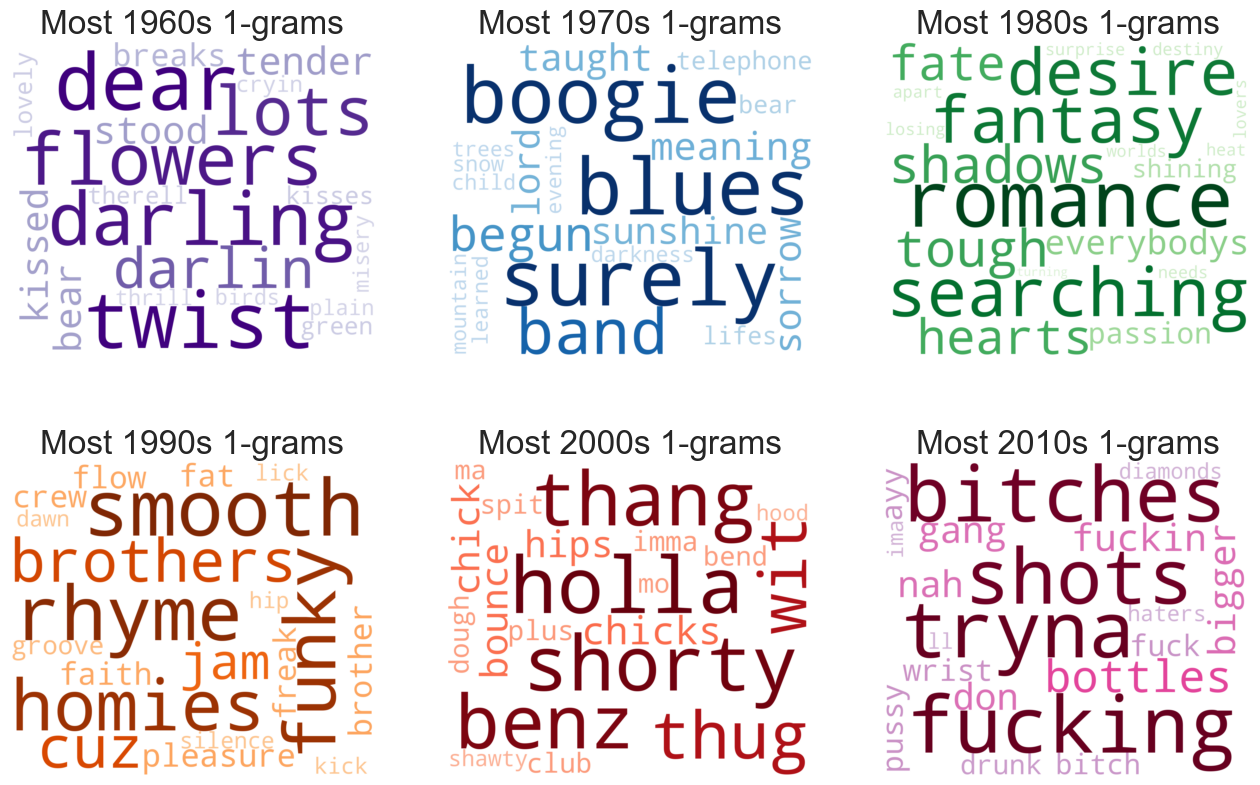

In [17]:
ngram_wordclouds()

## Most decade specific n-grams

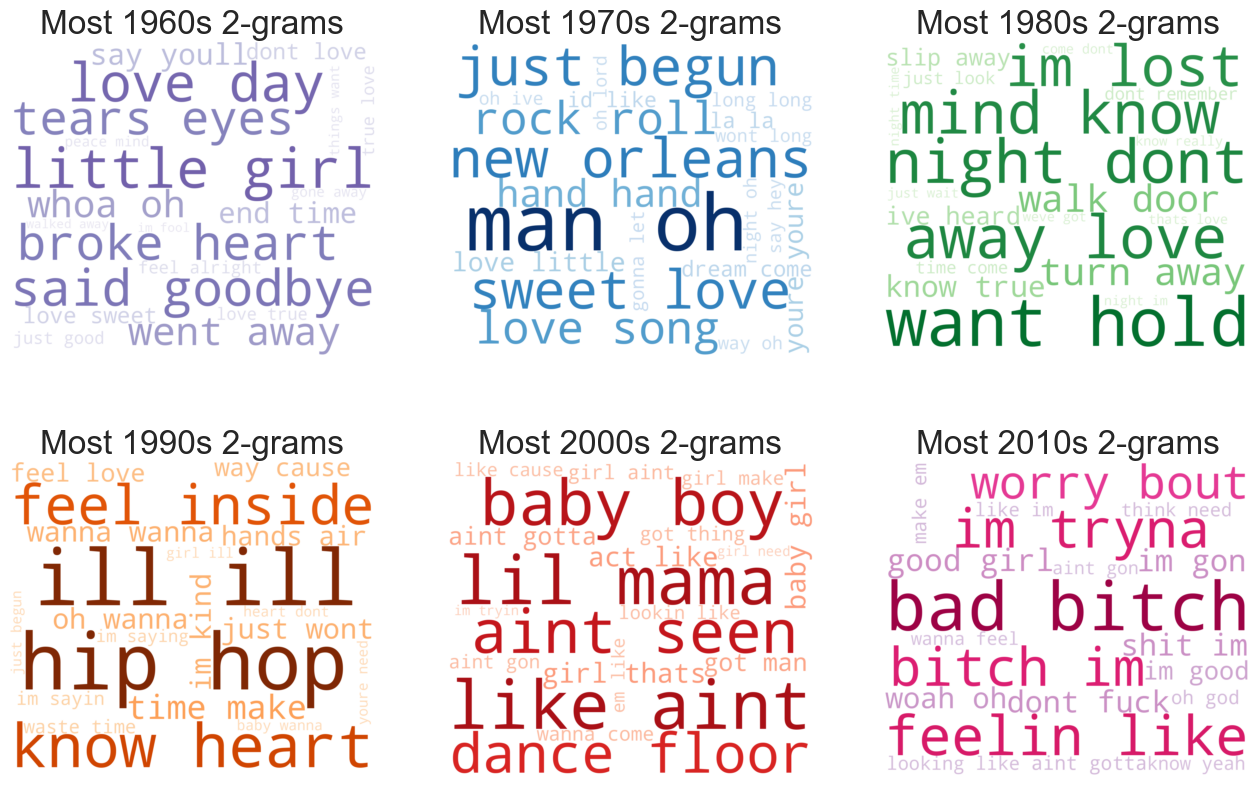

In [18]:
ngram_wordclouds(2, 30)

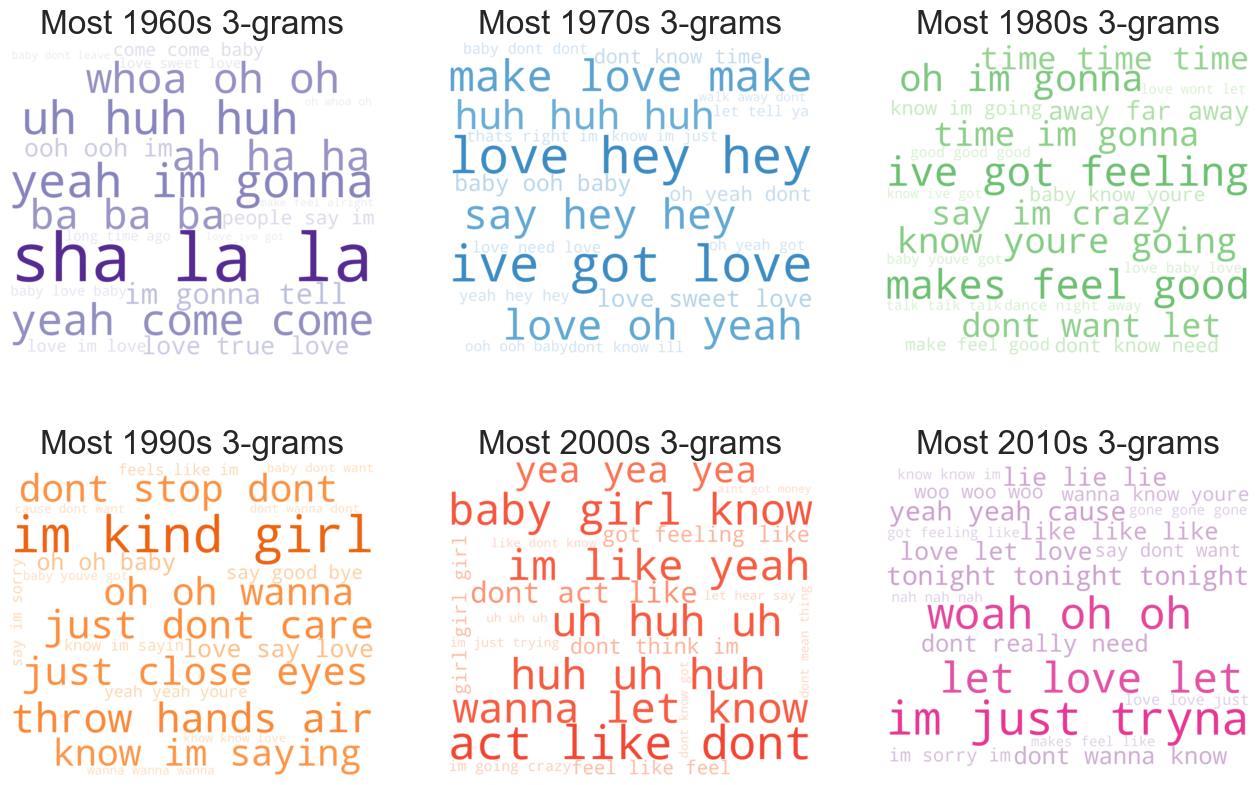

In [19]:
ngram_wordclouds(3, 10)

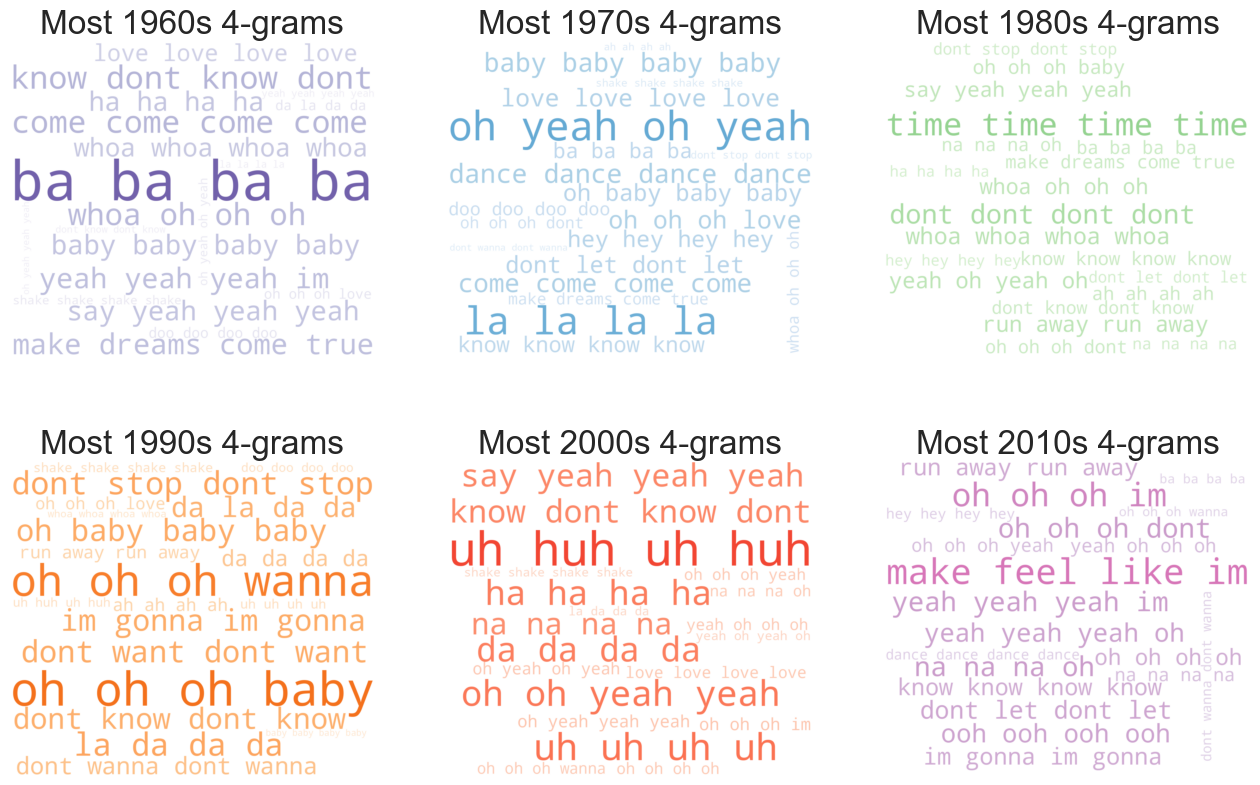

In [20]:
ngram_wordclouds(4, 10)